In [1]:
%pip install ipykernel nbformat plotly transformer_lens einops


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch

torch.set_default_device("mps")

## Model and configuration

### Configuration
1. batch_size = 4
2. input features = 5
3. output features = 2

### Model
Single layer neurons with 

$dim(W) = in\_features \times out\_features$

$dim(b) = out\_features$

$dim(x) = batch \times in\_features$

$y = sigmoid(x \cdot W + b)$

$dim(y) = batch \times out\_features$

In [3]:
from dataclasses import dataclass
from torch.nn import Module, init, Parameter
from torch.nn.functional import sigmoid

@dataclass
class Config:
    batch_size: int = 4
    in_features: int = 5
    out_features: int = 2

class Model(Module):
    def __init__(
        self, 
        config: Config,
    ) -> None:
        super().__init__()
        self.config = config
        self.W = Parameter(torch.empty(size=(config.in_features, config.out_features)))
        init.xavier_uniform_(self.W)
        self.b = Parameter(torch.zeros(size=(config.out_features,)))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = torch.einsum("bi,io->bo", x, self.W) + self.b
        return sigmoid(out)
    
    def generate_batch(self, batch_size: int) -> torch.Tensor:
        return (torch.rand(size=(batch_size, self.config.in_features))-0.5).ceil().abs()

### Test model output shape and batch generation shape

In [4]:
def should_have_correct_output_shape(input: torch.Tensor, expected_shape: torch.Size):
    cfg = Config()
    model = Model(cfg)
    output = model(input)
    assert expected_shape == output.shape
    
def should_generate_batch_with_correct_shape(expected_shape: torch.Size):
    cfg = Config()
    model = Model(cfg)
    batch = model.generate_batch(expected_shape[0])
    assert expected_shape == batch.shape

should_have_correct_output_shape(torch.randn(size=(4, 5)), torch.Size([4, 2]))
should_generate_batch_with_correct_shape(torch.Size([4, 5]))

## Define output function

$in\_features = 5$

assuming, `x0, x1, x2, x3, x4, ...`

and 

$out\_features = 2$

`y0, y1`

In [5]:
def output_fn(input: torch.Tensor) -> torch.Tensor:
    [batch_size, features] = input.shape
    assert 5 == features
    """ f(x0, x1, x2, x3, x4, ..., x7) = g(y1, y2) = ...
    """
    
    out = torch.empty(size=(batch_size, 2))
    t = input == 1
    x0 = t[:,0]
    x1 = t[:,1]
    x2 = t[:,2]
    x3 = t[:,3]
    x4 = t[:,4]
    
    out[:,0] = torch.logical_xor(torch.logical_and(x0, x1), x4).float()
    out[:,1] = torch.logical_or(torch.logical_and(x2, x3), torch.logical_not(x4)).float()
    
    return out

## Loss function

Assuming, $y$ is the expected function

and $y\prime$ is the actual function that model leart, we must calculate loss defined as:

$$L_i = \sum_{i} (y_i-y_i\prime)^2$$

In [6]:
import einops

def loss_fn(expected_output: torch.Tensor, actual_output: torch.Tensor) -> torch.Tensor:
    error = (expected_output.abs() - actual_output)**2
    loss = einops.reduce(error, 'b f -> 1', 'mean').sum()
    return loss

In [7]:
from typing import List
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_

def train(
    model: Model, 
    lr=1e-3, 
    betas=(0.9, 0.99),
    epochs=20000, 
    batch_size=4,
    print_every=1000,
) -> List[float]:
    losses = []
    optimizer = AdamW(model.parameters(), lr=lr, betas=betas)
    for epoch in range(epochs):
        batch = model.generate_batch(batch_size=batch_size)
        
        optimizer.zero_grad()
        
        actual_output = model(batch)
        
        expected_output = output_fn(batch)
        loss = loss_fn(expected_output, actual_output)
        loss.backward()
        
        clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % print_every == 0:
            print(f"Epoch: {epoch} loss: {loss.item()}")
    
    return losses

model = Model(Config())
losses = train(model, batch_size=64)

Epoch: 0 loss: 0.326842725276947
Epoch: 1000 loss: 0.19114884734153748
Epoch: 2000 loss: 0.13069677352905273
Epoch: 3000 loss: 0.12141971290111542
Epoch: 4000 loss: 0.11233580857515335
Epoch: 5000 loss: 0.1152743473649025
Epoch: 6000 loss: 0.1031869649887085
Epoch: 7000 loss: 0.09418725967407227
Epoch: 8000 loss: 0.09791560471057892
Epoch: 9000 loss: 0.061480019241571426
Epoch: 10000 loss: 0.03450022637844086
Epoch: 11000 loss: 0.07901937514543533
Epoch: 12000 loss: 0.0755094513297081
Epoch: 13000 loss: 0.08746597170829773
Epoch: 14000 loss: 0.06954952329397202
Epoch: 15000 loss: 0.06726285815238953
Epoch: 16000 loss: 0.07430586218833923
Epoch: 17000 loss: 0.10393305867910385
Epoch: 18000 loss: 0.05701059475541115
Epoch: 19000 loss: 0.06407731771469116


### Plot losses

In [8]:
import plotly.express as px

px.line(losses, labels={"x": "steps", "y": "loss", "variable": "loss"})

In [9]:
def validate_model(batch_size=1):
    intput = model.generate_batch(batch_size=batch_size)
    expected_output = output_fn(intput)
    actual_output = model(intput)
    
    print(actual_output)
    print(expected_output)

validate_model(2)

tensor([[9.3767e-01, 9.6860e-01],
        [2.9514e-04, 9.9997e-01]], device='mps:0', grad_fn=<SigmoidBackward0>)
tensor([[1., 1.],
        [0., 1.]], device='mps:0')


### Let's evaluate W and b in the toy model

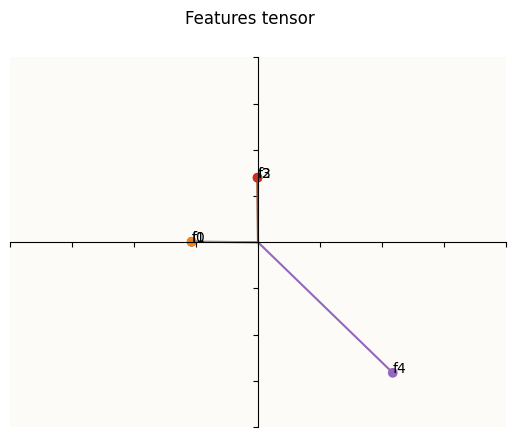

Parameter containing:
tensor([-2.7355,  3.5596], device='mps:0', requires_grad=True)

In [10]:
import matplotlib.pyplot as plt
from matplotlib import colors  as mcolors
from transformer_lens.utils import to_numpy


def plot_features(model: Model):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    
    features = model.W.cpu().detach().numpy()
    x_data, y_data = features[:,0], features[:,1]
    colors = [mcolors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
    ax.scatter(x_data, y_data, c=colors[0: len(x_data)])
    
    for f in range(model.config.in_features):
        point = (features[f,0], features[f,1])
        ax.plot([0,point[0]], [0,point[1]])
        ax.annotate(f"f{f}", point)
    
    z = 20
    ax.set_facecolor('#FCFBF8')
    ax.set_xlim((-z,z))
    ax.set_ylim((-z,z))
    ax.tick_params(left = True, right = False, labelleft = False, labelbottom = False, bottom = True)
    
    # display xy axes with origin at center of the figure
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom','left']:
        ax.spines[spine].set_position('center')
    
    fig.suptitle(f"Features tensor")
    plt.show()
    
def plot_feat_intersection(model):
    cell_size = 100
    row_title_width = 50
    width = cell_size*model.config.in_features + row_title_width
    height = cell_size*model.config.in_features
    
    W = model.W.cpu().detach()
    img_data = []
    for f1 in range(model.config.in_features):
        img_data.append([])
        for f2 in range(model.config.in_features):
            img_data[f1].append(torch.dot(W[f1], W[f2]).item())

    features = [f"f{f}" for f in range(model.config.in_features)]
    img = px.imshow(
        to_numpy(img_data), 
        x=features, 
        y=features, 
        labels={"x": "feature", "y": "feature"}, 
        title=f"Dot product of features",
        color_continuous_midpoint=0,
        color_continuous_scale="RdBu",
        height=height,
        width=width
    )
    
    for f in range(model.config.in_features):
        img.add_shape(type="line", x0=0.5+f, y0=-0.5, x1=0.5+f, y1=model.config.in_features-0.5, line=dict(color="white", width=2))
        img.add_shape(type="line", x0=-0.5, y0=0.5+f, x1=model.config.in_features-0.5, y1=0.5+f, line=dict(color="white", width=2))
    
    img.show()

plot_features(model)
plot_feat_intersection(model)
model.b

## Analysis

TBD.. I haven't completely formulated my ideas on this one for now. But I can draw following intuitions:
1. `f1 AND f2` - feature tensors `f1` and `f2` are aligned in the same direction. 
2. `f1 OR f2` - feature tensors `f1` and `f2` are orthogonal.
3. `NOT f1` - feature tensor `f1` is flipped and it makes a more interesting case when it combines with other gates.

I will be doing more analysis on biases, as they will play a significant role in adjusting values.